## Relative Strength Index (RSI)

RSI is an indicator which can help guide investors as when to buy/sell a given stock.

Average Gain and Loss is looked at over a period of time, and an RSI value is calculated as

$$ RSI = 100 - {100 \over 1+{Avg Gain \over Avg Loss}} $$

Generally if $RSI<30$ then the stock is **underbought** (so buy) and if $RSI>70$ then stock is **overbought** (so sell).

So we have 2 'hyperparameters' when considering this indicator:

* Lookback period
* RSI thresholds

In [52]:
import pandas as pd
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [16]:
## Get APPLE Stock data from the last 4 years
df = yf.download("AAPL", start="2020-01-01", end="2024-12-01", multi_level_index=False)

print(df.head())

[*********************100%***********************]  1 of 1 completed

            Adj Close      Close       High        Low       Open     Volume
Date                                                                        
2020-01-02  72.796013  75.087502  75.150002  73.797501  74.059998  135480400
2020-01-03  72.088287  74.357498  75.144997  74.125000  74.287498  146322800
2020-01-06  72.662720  74.949997  74.989998  73.187500  73.447502  118387200
2020-01-07  72.320969  74.597504  75.224998  74.370003  74.959999  108872000
2020-01-08  73.484352  75.797501  76.110001  74.290001  74.290001  132079200


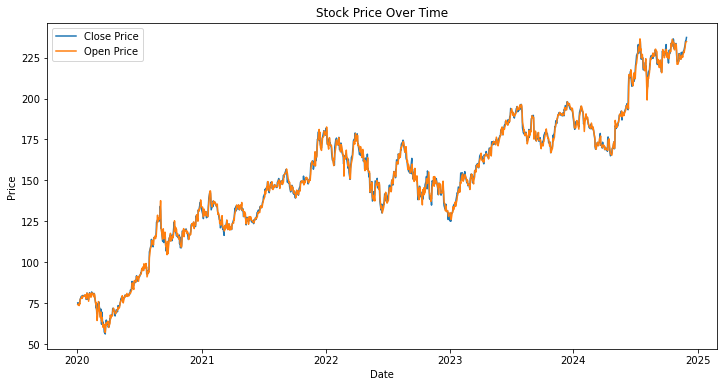

In [128]:
# View the dataset
plt.figure(figsize=(12, 6))
plt.plot(df.index, df.Close, label='Close Price')
plt.plot(df.index, df.Open, label='Open Price')
plt.ylabel('Price')  # Use plt.ylabel instead of plt.set_ylabel
plt.xlabel('Date')   # Add an x-axis label for better clarity
plt.title('Stock Price Over Time')  # Add a title for the plot
plt.legend()  # Show the legend
plt.show()


In [19]:
def RSI(data: pd.Series, period: int = 14):    
    
    # Calculate daily differences
    diff = data.diff()
    
    # Separate gains and losses
    gains = diff.clip(lower=0)
    losses = -diff.clip(upper=0)
    
    # Calculate EMA for gains and losses
    avg_gains = gains.ewm(span=period, adjust=False).mean()
    avg_losses = losses.ewm(span=period, adjust=False).mean()
    
    # Calculate RS and RSI
    RS = avg_gains / avg_losses
    RSI = 100 - (100 / (1 + RS))
    
    return RSI


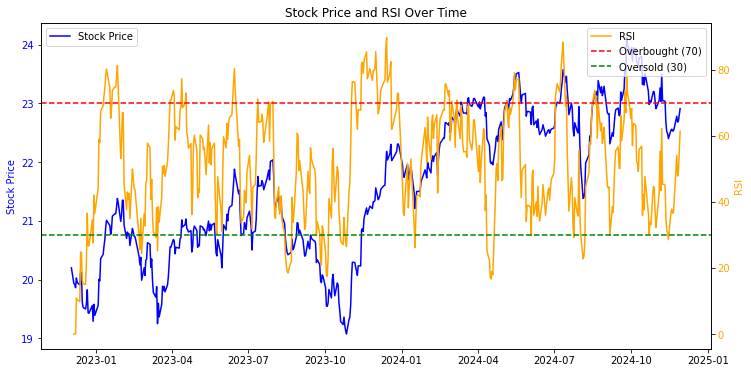

In [136]:
# Plot RSI and stock price
fig, ax1 = plt.subplots(figsize=(12, 6))

# Stock Price Plot
ax1.plot(df.index, df.Close, label='Stock Price', color='blue')
ax1.set_ylabel("Stock Price", color="blue")
ax1.tick_params(axis='y', labelcolor="blue")
ax1.legend(loc="upper left")

# RSI Plot
ax2 = ax1.twinx()
ax2.plot(df.index, RSI(df.Close,14), label='RSI', color='orange')
ax2.axhline(70, color='red', linestyle='--', label='Overbought (70)')
ax2.axhline(30, color='green', linestyle='--', label='Oversold (30)')
ax2.set_ylabel("RSI", color="orange")
ax2.tick_params(axis='y', labelcolor="orange")
ax2.legend(loc="upper right")

plt.title("Stock Price and RSI Over Time")
plt.show()

Buying and selling stock purely based off $RSI$ seems somewhat useful. The Price sometimes rises after $RSI<30$ and drops after $RSI>70$, but this does not seem consistent.

Let's explore how RSI performs on stocks that have not done as well as Apple, and stocks that are more and less volatile.

In [140]:
## Get JD Stock data from the last 4 years
df = yf.download("JD", start="2020-01-01", end="2024-12-01", multi_level_index=False)


[*********************100%***********************]  1 of 1 completed


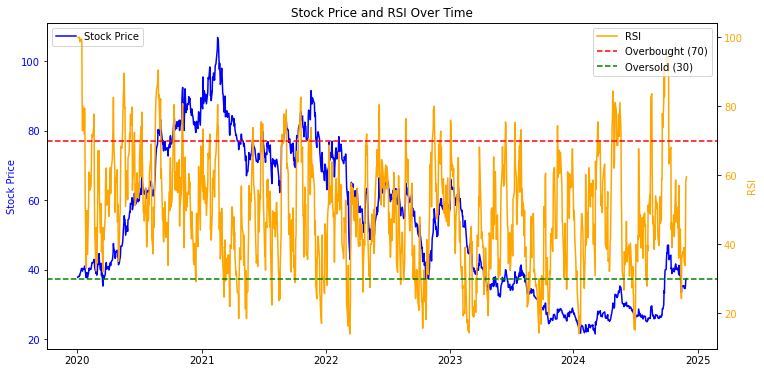

In [142]:
# Plot RSI and stock price
fig, ax1 = plt.subplots(figsize=(12, 6))

# Stock Price Plot
ax1.plot(df.index, df.Close, label='Stock Price', color='blue')
ax1.set_ylabel("Stock Price", color="blue")
ax1.tick_params(axis='y', labelcolor="blue")
ax1.legend(loc="upper left")

# RSI Plot
ax2 = ax1.twinx()
ax2.plot(df.index, RSI(df.Close,14), label='RSI', color='orange')
ax2.axhline(70, color='red', linestyle='--', label='Overbought (70)')
ax2.axhline(30, color='green', linestyle='--', label='Oversold (30)')
ax2.set_ylabel("RSI", color="orange")
ax2.tick_params(axis='y', labelcolor="orange")
ax2.legend(loc="upper right")

plt.title("Stock Price and RSI Over Time")
plt.show()

It does seem to have some predictive power, but doesn't seem so reliable by itself.

Now we'll run a simulation to trade naively using $RSI$ to see how well it actually does.

[*********************100%***********************]  1 of 1 completed


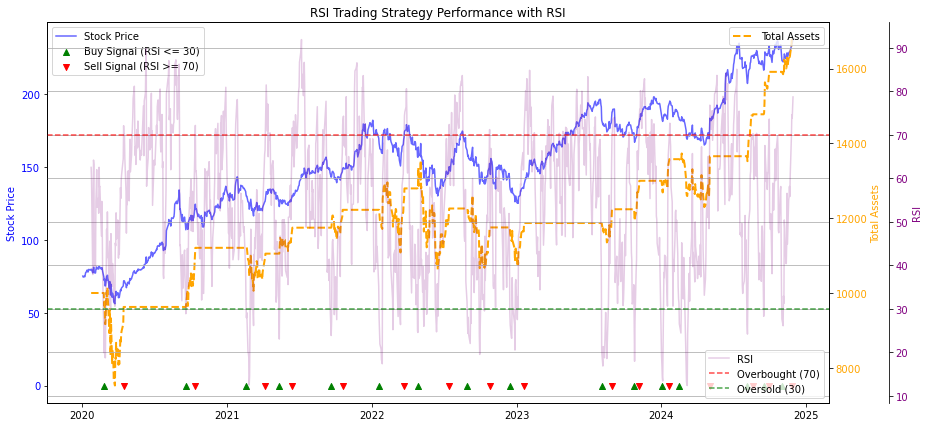

Final Bank Amount: $16773.43
Final Stock Count: 0
Final Total Assets: $16773.43
Total Returns: 67.73%


In [159]:
## Get APPLE Stock data from the last 4 years
df = yf.download("AAPL", start="2020-01-01", end="2024-12-01", multi_level_index=False)

import math
import matplotlib.pyplot as plt

# RSI calculation (assuming you have the RSI function)
df_rsi = RSI(df['Close'], 14)
df_rsi = df_rsi.iloc[14:]  # Remove the first 14 days, as RSI is not calculated for them

# Start with $10,000 in the bank
initial_bank_amount = 10000
bank_amount = initial_bank_amount

# No stock initially
stock_count = 0

# Track total assets over time
total_assets_over_time = []
dates = []
buy_signals = []
sell_signals = []

# Iterate through every day to simulate trading
for date in df_rsi.index:
    # Get stock value and RSI value
    stock_value = df['Close'].loc[date]
    rsi_value = df_rsi.loc[date]
    
    # If RSI is below 30, buy as many shares as possible
    if rsi_value <= 30:
        num_stock_can_afford = math.floor(bank_amount / stock_value)
        if num_stock_can_afford > 0:
            bank_amount -= stock_value * num_stock_can_afford
            stock_count += num_stock_can_afford
            buy_signals.append((date, 0))  # Record buy action
    
    # If RSI is above 70, sell all shares
    elif rsi_value >= 70 and stock_count > 0:
        bank_amount += stock_value * stock_count
        sell_signals.append((date, 0))  # Record sell action
        stock_count = 0
    
    # Calculate total assets (bank + stock value)
    total_assets = bank_amount + stock_count * stock_value
    total_assets_over_time.append(total_assets)
    dates.append(date)

# Plot the results
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot stock price on the primary y-axis
ax1.plot(df['Close'], label="Stock Price", color='blue', alpha=0.6)
ax1.scatter(*zip(*buy_signals), label="Buy Signal (RSI <= 30)", marker="^", color='green')
ax1.scatter(*zip(*sell_signals), label="Sell Signal (RSI >= 70)", marker="v", color='red')
ax1.set_ylabel("Stock Price", color="blue")
ax1.tick_params(axis='y', labelcolor="blue")
ax1.legend(loc="upper left")

# Plot total asset growth on the secondary y-axis
ax2 = ax1.twinx()
ax2.plot(dates, total_assets_over_time, label="Total Assets", color='orange', linestyle='--', linewidth=2)
ax2.set_ylabel("Total Assets", color="orange")
ax2.tick_params(axis='y', labelcolor="orange")
ax2.legend(loc="upper right")

# Add RSI to the same figure using a new axis
ax3 = ax1.twinx()
ax3.spines["right"].set_position(("outward", 60))  # Offset the third axis
ax3.plot(df_rsi.index, df_rsi, label="RSI", color='purple', linestyle='-', alpha=0.2)
ax3.axhline(70, color='red', linestyle='--', alpha=0.7, label='Overbought (70)')
ax3.axhline(30, color='green', linestyle='--', alpha=0.7, label='Oversold (30)')
ax3.set_ylabel("RSI", color="purple")
ax3.tick_params(axis='y', labelcolor="purple")
ax3.legend(loc="lower right")

# Add title and labels
plt.title("RSI Trading Strategy Performance with RSI")
plt.xlabel("Date")
plt.grid(True)

plt.show()

# Print final results
print(f"Final Bank Amount: ${bank_amount:.2f}")
print(f"Final Stock Count: {stock_count}")
print(f"Final Total Assets: ${total_assets_over_time[-1]:.2f}")
print(f"Total Returns: {((total_assets_over_time[-1] / initial_bank_amount) - 1) * 100:.2f}%")


[*********************100%***********************]  1 of 1 completed


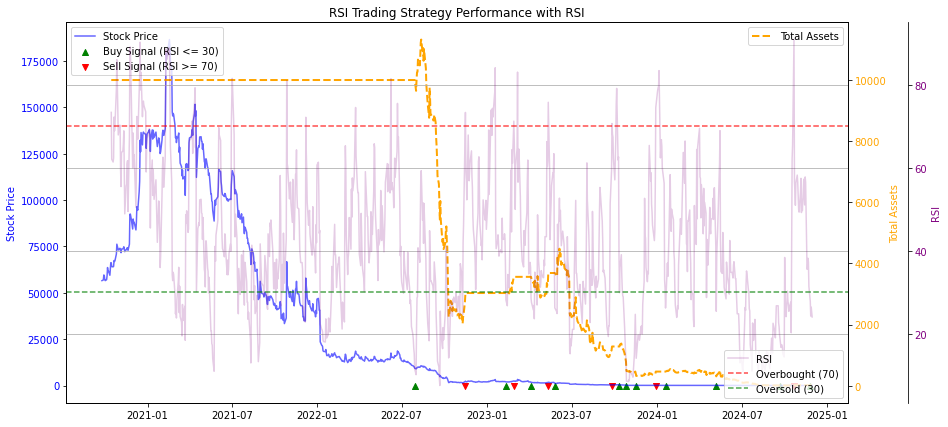

Final Bank Amount: $0.76
Final Stock Count: 17
Final Total Assets: $15.26
Total Returns: -99.85%


In [162]:
## Get SYTA Stock data from the last 4 years
df = yf.download("SYTA", start="2020-01-01", end="2024-12-01", multi_level_index=False)


import math
import matplotlib.pyplot as plt

# RSI calculation (assuming you have the RSI function)
df_rsi = RSI(df['Close'], 14)
df_rsi = df_rsi.iloc[14:]  # Remove the first 14 days, as RSI is not calculated for them

# Start with $10,000 in the bank
initial_bank_amount = 10000
bank_amount = initial_bank_amount

# No stock initially
stock_count = 0

# Track total assets over time
total_assets_over_time = []
dates = []
buy_signals = []
sell_signals = []

# Iterate through every day to simulate trading
for date in df_rsi.index:
    # Get stock value and RSI value
    stock_value = df['Close'].loc[date]
    rsi_value = df_rsi.loc[date]
    
    # If RSI is below 30, buy as many shares as possible
    if rsi_value <= 30:
        num_stock_can_afford = math.floor(bank_amount / stock_value)
        if num_stock_can_afford > 0:
            bank_amount -= stock_value * num_stock_can_afford
            stock_count += num_stock_can_afford
            buy_signals.append((date, 0))  # Record buy action
    
    # If RSI is above 70, sell all shares
    elif rsi_value >= 70 and stock_count > 0:
        bank_amount += stock_value * stock_count
        sell_signals.append((date, 0))  # Record sell action
        stock_count = 0
    
    # Calculate total assets (bank + stock value)
    total_assets = bank_amount + stock_count * stock_value
    total_assets_over_time.append(total_assets)
    dates.append(date)

# Plot the results
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot stock price on the primary y-axis
ax1.plot(df['Close'], label="Stock Price", color='blue', alpha=0.6)
ax1.scatter(*zip(*buy_signals), label="Buy Signal (RSI <= 30)", marker="^", color='green')
ax1.scatter(*zip(*sell_signals), label="Sell Signal (RSI >= 70)", marker="v", color='red')
ax1.set_ylabel("Stock Price", color="blue")
ax1.tick_params(axis='y', labelcolor="blue")
ax1.legend(loc="upper left")

# Plot total asset growth on the secondary y-axis
ax2 = ax1.twinx()
ax2.plot(dates, total_assets_over_time, label="Total Assets", color='orange', linestyle='--', linewidth=2)
ax2.set_ylabel("Total Assets", color="orange")
ax2.tick_params(axis='y', labelcolor="orange")
ax2.legend(loc="upper right")

# Add RSI to the same figure using a new axis
ax3 = ax1.twinx()
ax3.spines["right"].set_position(("outward", 60))  # Offset the third axis
ax3.plot(df_rsi.index, df_rsi, label="RSI", color='purple', linestyle='-', alpha=0.2)
ax3.axhline(70, color='red', linestyle='--', alpha=0.7, label='Overbought (70)')
ax3.axhline(30, color='green', linestyle='--', alpha=0.7, label='Oversold (30)')
ax3.set_ylabel("RSI", color="purple")
ax3.tick_params(axis='y', labelcolor="purple")
ax3.legend(loc="lower right")

# Add title and labels
plt.title("RSI Trading Strategy Performance with RSI")
plt.xlabel("Date")
plt.grid(True)

plt.show()

# Print final results
print(f"Final Bank Amount: ${bank_amount:.2f}")
print(f"Final Stock Count: {stock_count}")
print(f"Final Total Assets: ${total_assets_over_time[-1]:.2f}")
print(f"Total Returns: {((total_assets_over_time[-1] / initial_bank_amount) - 1) * 100:.2f}%")
